# 5.2.2 데이터 분할 및 대체 

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# pip install -U imbalanced-learn

In [13]:
# 참조 코딩
import imblearn
print(imblearn.__version__)

0.11.0


In [14]:
!pip install graphviz

In [15]:
import graphviz

In [16]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book2/Ch5/healthcare-dataset-3.csv')
df.shape

(3915, 11)

In [17]:
# 참조 코딩 (아래 코딩을 실행 안해도 추후 결과는 동일합니다.)
# dtype을 category로 지정해 줄 변수들을 cols2에 임시 저장
cols2 = ['hypertension', 'heart_disease', 'stroke', 'ever_married_encoded', 'gender_encoded',
         'work_type_encoded', 'residence_type_encoded', 'smoking_status_encoded']

df[cols2] = df[cols2].astype('category')   # cols2에 저장된 변수들의 dtype을 category로 변경

In [18]:
data = df.drop(['stroke'], axis=1)   # 타겟변수를 제외한 변수만 data에 저장
target = df['stroke']                # 타겟변수만 target에 저장
data.shape

(3915, 10)

In [19]:
target.shape

(3915,)

In [20]:
df['stroke'].value_counts(dropna=False)

0    3722
1     193
Name: stroke, dtype: int64

In [21]:
df['stroke'].value_counts(dropna=False, normalize=True)

0    0.950702
1    0.049298
Name: stroke, dtype: float64

In [22]:
from imblearn.under_sampling import RandomUnderSampler    # RandomUnderSampler를 import
undersample = RandomUnderSampler(sampling_strategy=0.333, random_state=2) 
                                                          # 타겟변수의 소수 클래스 및 다수 클래스를
                                                          # 1:3의 비율(=1/3)로 언더샘플링
data_under, target_under = undersample.fit_resample(data, target)
                                                          # data 및 target에 언더샘플링 적용

In [23]:
target_under.value_counts(dropna=True)

0    579
1    193
Name: stroke, dtype: int64

In [24]:
target_under.value_counts(dropna=True, normalize=True)

0    0.75
1    0.25
Name: stroke, dtype: float64

In [25]:
# 50:50 비율로 데이터 분할
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
    data_under, target_under, test_size=0.5, random_state=42, stratify = target_under)

print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 

X_train shape: (386, 10)
X_test shape: (386, 10)


In [26]:
print("y_train shape:", y_train.shape) 
print("y_test shape:", y_test.shape) 

y_train shape: (386,)
y_test shape: (386,)


In [27]:
y_train.value_counts(normalize=True)

0    0.748705
1    0.251295
Name: stroke, dtype: float64

In [28]:
y_train.value_counts()

0    289
1     97
Name: stroke, dtype: int64

# 5.3 결정 트리(Decision Tree) 분류 모델

In [41]:
# Decision Tree 모델 (Default인 GINI기준이자 Maximal depth 조건)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
tree = DecisionTreeClassifier(random_state=0)   # Classifier로 DecisionTreeClassifer 지정
model = tree.fit(X_train, y_train)   # Clssifier를 트레이닝 데이터셋에서 학습시킴
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성
 
print("Accuracy(GINI) on training set:{:.5f}".format(model.score(X_train, y_train))) 
print("Accuracy(GINI) on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy(GINI) on training set:1.00000
Accuracy(GINI) on test set:0.69171


In [30]:
# Decision Tree 모델 (Gini 기준)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(criterion="gini", random_state=0, max_depth=5) 

params = {'criterion':['gini','entropy'],'max_depth': range(1,21)}

grid_tree = GridSearchCV(tree, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1,
                     verbose=1)
grid_tree.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_tree.best_score_))
print("GridSearchCV best parameter:", (grid_tree.best_params_))  

Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearchCV max accuracy:0.79534
GridSearchCV best parameter: {'criterion': 'gini', 'max_depth': 4}


In [45]:
# 참조 코딩
# range() 함수의 결과를 디스플레이

for i in range(1,21):
    print(i, end =" ")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [47]:
best_clf = grid_tree.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on test set:0.76943


In [46]:
# 참조 코딩
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

ROC AUC on test set:0.76651


In [49]:
print ("Feature importances:") 
print (best_clf.feature_importances_) 

Feature importances:
[0.62704795 0.03801011 0.         0.14192898 0.11210499 0.
 0.         0.         0.03342888 0.0474791 ]


In [35]:
# 변수명을 Index로 만들고 feature_importances를 매칭해서 나열한 데이터프레임 만들기 

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.round(best_clf.feature_importances_, 4), index=feature_names,
                   columns=['Feature_importances'])
dft1 = dft.sort_values(by='Feature_importances', ascending=False)   
dft1                                 # 컬럼 Feature_importances의 값들을 내림차순으로 정리 

,Feature_importances
age,0.6270
avg_glucose_level,0.1419
bmi,0.1121
smoking_status_encoded,0.0475
hypertension,0.0380
residence_type_encoded,0.0334
heart_disease,0.0000
ever_married_encoded,0.0000
gender_encoded,0.0000
work_type_encoded,0.0000


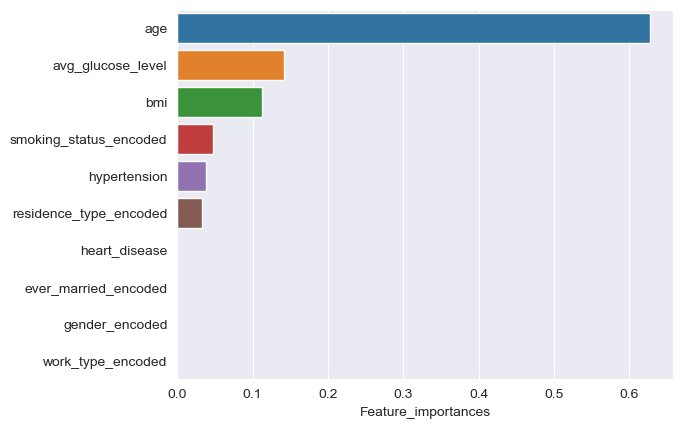

In [36]:
# 데이터프레임 dft1의 막대그래프 그리기

import seaborn as sns
sns.barplot(y=dft1.index, x="Feature_importances", data=dft1);

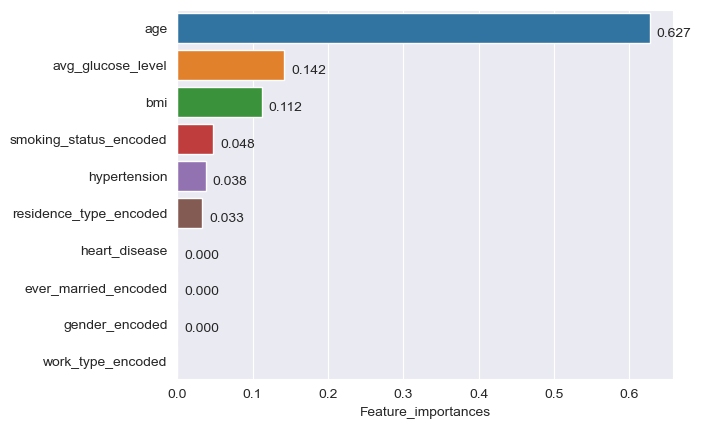

In [37]:
# 참조 코딩
# 데이터프레임 dft1의 막대그래프 그리기 및 값 표시
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.barplot(y=dft1.index, x="Feature_importances", data=dft1)

for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+1),
                xytext=(5, 10), textcoords='offset points')

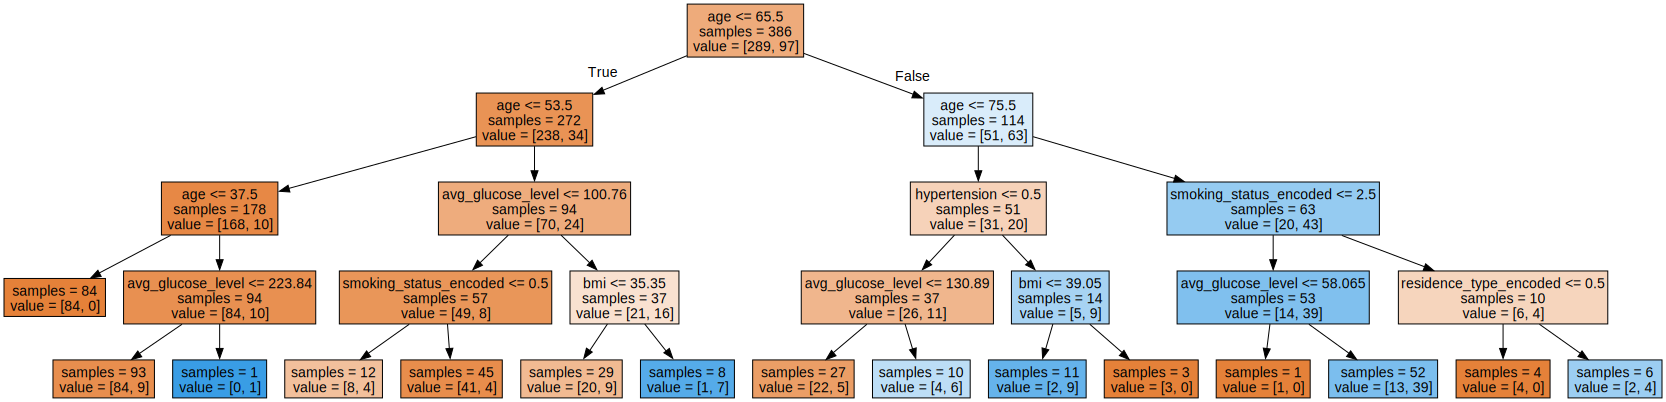

In [38]:
# model의 결과물을 tree.dot에 저장      
import graphviz
from sklearn.tree import export_graphviz 
export_graphviz(best_clf, out_file = "tree.dot",   
                feature_names = list(data.columns), impurity = False , filled = True )

# tree.dot을 graphviz 기능을 통해 디스플레이.
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read() 
display(graphviz.Source(dot_graph)) 

In [39]:
# 참조 코딩
# 위의 코딩문으로 graphviz가 설치됐는데도 코랩에서 결정트리 결과물 디스플레이가 안될 때 
# 추가로 시도해 보는 코드

# Install graphviz on Colab 
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

zsh:1: command not found: apt-get


ModuleNotFoundError: No module named 'pydot'